In [2]:
import torch 
from setup import fetch_data 
from plotting import plot_from_dataset, plot_random_image

# use GPU if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# define constants 
BATCH_SIZE = 1
IMAGE_SIZE = 128

# load dataset and dataloaders 

train_data, test_data, train_dataloader, test_dataloader = fetch_data(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
labels_dict = train_data.idx_to_class


cpu


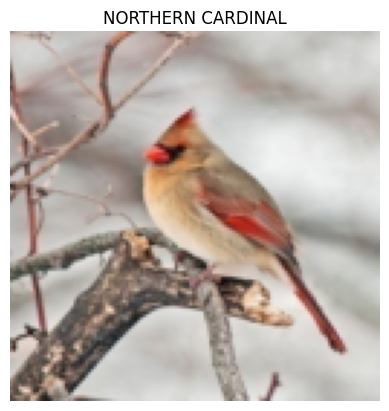

In [4]:
plot_from_dataset(train_data, labels_dict, 375); 

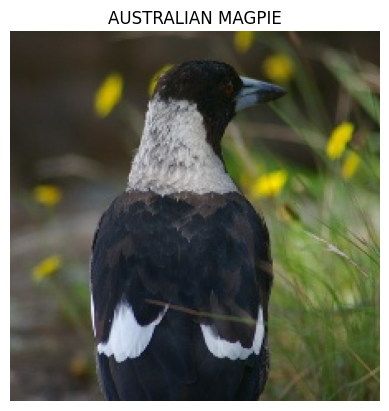

In [5]:
plot_random_image("data/reduced"); 

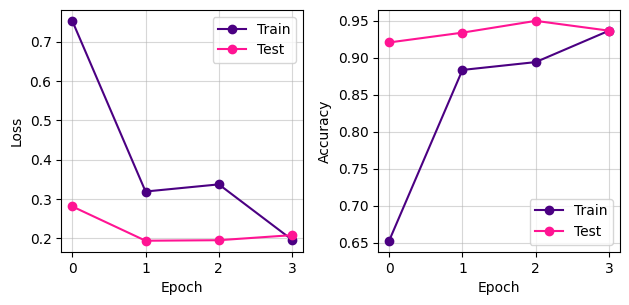

In [4]:
from plotting import plot_results
from utils import load_model, load_results
from models import TinyVGG 

# load the model
model_loaded = TinyVGG(in_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_shape=len(train_data.classes)).to(device)
load_model(model_loaded, f"{model_loaded.name()}.pth")
# model_loaded.state_dict() 

model_results = load_results(f"{model_loaded.name()}")

plot_results(model_results)

In [5]:
# test the model on an image it has not seen 
import requests
import pathlib
image_path = pathlib.Path("data/validation/HOUSE SPARROW.jpg")
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/612827980/1200"

if not image_path.is_file():
    try: 
        r = requests.get(image_url)
        if r.status_code == 200: 
            with open(image_path, "wb") as f: 
                f.write(r.content)
                print("[INFO] Writing to file...")
    except: 
        print("Exception occurred")

Predicted label: HOUSE SPARROW with 88.14% probability.


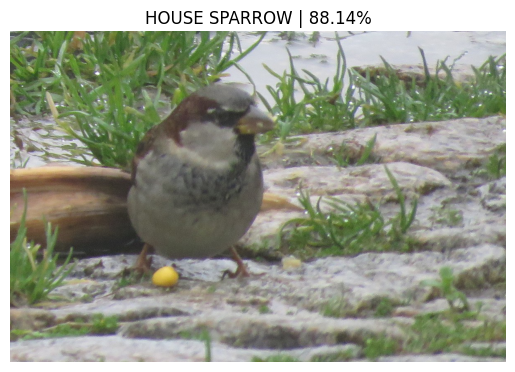

In [6]:
import torchvision
import matplotlib.pyplot as plt
from engine import predict 

custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255

resizer = torchvision.transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True) 

probs, prediction = predict(model=model_loaded, image_tensor=custom_image, transform=resizer, labels_dict=labels_dict, device=device)

plt.imshow(custom_image.to("cpu").permute(1,2,0)) 
plt.axis("off") 
plt.title(f"{prediction} | {probs.max() * 100:.2f}%")
plt.show()